# Character Prediction

We aim to do a text prediction with LSTM RNN with Keras. In this notebook we will explore various approaches for the prediction including modifying the layers, the optimizers, the epochs and the batches. Further, we will do hypertuning with Keras to try to achieve the best possible model.

### Install the required packages

In [2]:
! pip install keras-tuner

### Check if the the GPU is available.

In [3]:
from tensorflow.config import list_physical_devices
list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Import the required libraries

In [4]:
import os
import pandas as pd
import keras_tuner
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Creating the Training Dataset

We will be creating the training dataset for our model.

In [5]:
book_url = "https://www.gutenberg.org/cache/epub/11592/pg11592.txt"
filepath = tf.keras.utils.get_file("book.txt", book_url)
with open(filepath, encoding='utf-8-sig') as f:
    book_text = f.read()

49152/36232 [========================================] - 0s 0us/step


### Explore the Dataset

The dataset will be explored in order to know more about the dataset.

The type of the variable 'book_test' i.e. the test dataset is printed and it is of 'str' type.

In [6]:
print(type(book_text))

<class 'str'>


Next, we try to see the size of our dataset and it is 35,427 characters.

In [7]:
print(f'Number of characters in the text: {len(book_text):,}')

Number of characters in the text: 35,427


In [8]:
print(book_text[:100])

The Project Gutenberg eBook, Children's Hour with Red Riding Hood and
Other Stories, Edited by Watty


We see how many distinct characters we have in our dataset and it is 58 characters.

In [9]:
distinct_chars = "".join(sorted(set(book_text.lower())))
print(f'Number of distinct characters: {len(distinct_chars)}')

Number of distinct characters: 58


In [10]:
distinct_chars

'\n !"#$%\'()*,-./0123456789:;?@[]_abcdefghijklmnopqrstuvwxyz'

### Preprocess the Data
(Code is referenced for this section using the class notes)

Now, lets move on to the preprocessing for our dataset.

Firstly, we set split = 'character' to get the character level encoding. We also use standardize = 'lower' to convert the text to lowercase for simplification.

In [11]:
def custom_split(input_data):
    return tf.strings.unicode_split(input_data,'UTF-8')
def custom_standardize(input_data):
    return tf.strings.lower(input_data)
text_vec_layer = tf.keras.layers.TextVectorization(
    split = custom_split,
#     split='character',
#     standardize='lower'
    standardize = custom_standardize
)

Each character is now mapped to an integer, starting at 2. The `TextVectorization`
layer reserved the value 0 for padding tokens, and it reserved 1 for unknown characters. We won’t need either of these tokens for now, so let’s subtract 2 from the
character IDs

In [12]:
text_vec_layer

In [13]:
text_vec_layer.adapt([book_text])

2023-02-13 01:12:57.673383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
encoded = text_vec_layer([book_text])[0]

In [15]:
encoded

<tf.Tensor: shape=(35427,), dtype=int64, numpy=array([ 4, 10,  3, ..., 35, 35, 15])>

In [16]:
encoded -= 2 #TODO: decide  # drop tokens 0 (pad) and 1 (unknown), which we will not use
encoded

<tf.Tensor: shape=(35427,), dtype=int64, numpy=array([ 2,  8,  1, ..., 33, 33, 13])>

In [17]:
n_tokens = text_vec_layer.vocabulary_size() - 2 
print(f'Number of distinct tokens: {n_tokens}')

Number of distinct tokens: 58


In [18]:
dataset_size = len(encoded)
print(f'Number of tokens: {dataset_size:,}')

Number of tokens: 35,427


### Dividing the data into windows of datasets

we can turn this very long sequence into a dataset of windows that we can then use to train a sequence-to-sequence RNN. The targets will be similar to the inputs, but shifted by one time step into the “future”. For example, one sample in the dataset may be a sequence of character IDs representing the text “to be or not to b” (without the final “e”), and the corresponding target — a sequence of character IDs representing the text “o be or not to be” (with the final “e”, but without the leading “t”). Let’s write a small utility function to convert a long sequence of character IDs into a dataset of input/target window pairs:

In [19]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [20]:
length = 30
tf.random.set_seed(36)
train_set = to_dataset(encoded[:30_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[30_000:32_000], length=length)
test_set = to_dataset(encoded[32_000:], length=length)

In [21]:
train_set

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>

### Building Base Model with RNN

In our first approach, we will try to build a base sequential model with 3 layers. The first layer will be the Embedding layer, the second layer will be a GRU layer with 128 neurons and the third layer will be a Dense layer with the activation function as 'Softmax'.
The loss function and the optimizer will be 'sparse_categorical_crossentropy' and 'nadam' respectively.
Lastly, we will save the model.

In [22]:
if os.path.isfile('model.h5'):
  model = tf.keras.models.load_model('model.h5')
  history = pd.read_csv('history.csv')
else:
    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
      tf.keras.layers.GRU(128, return_sequences=True),
      tf.keras.layers.Dense(n_tokens, activation="softmax")
  ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        "base_model", monitor="val_accuracy", save_best_only=True)
    history = model.fit(train_set, validation_data=valid_set, epochs=100,
                        callbacks=[model_ckpt])
    history = pd.DataFrame(history.history)
    #save model
    model.save('model.h5', save_format='h5')
    history.to_csv('history.csv',header=True)

Lets write a small utility function to display the train and test datasets loss and accuracy.

In [23]:
def present_score(prefix, model, dataset):
    score_opt = model.evaluate(dataset)

    print(f"{prefix} Loss:", score_opt[0])
    print(f"{prefix} Accuracy:", score_opt[1])

The train accuracy and for our base model:

In [24]:
present_score('Train', model, train_set)

2023-02-13 01:13:02.340998: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


937/937 [==============================] - 9s 4ms/step - loss: 0.4187 - accuracy: 0.8811
Train Loss: 0.41871458292007446
Train Accuracy: 0.8810532689094543


The test accuracy and for our base model:

In [25]:
present_score('Test', model, test_set)

107/107 [==============================] - 1s 6ms/step - loss: 4.2680 - accuracy: 0.4408
Test Loss: 4.268008232116699
Test Accuracy: 0.44083014130592346


In [26]:
history

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.359940,0.340612,2.415867,0.373350
1,1,1.539968,0.559993,2.273280,0.452301
2,2,1.211400,0.647184,2.366187,0.458409
3,3,1.023970,0.700796,2.494873,0.456988
4,4,0.907770,0.735016,2.617894,0.455821
...,...,...,...,...,...
95,95,0.429992,0.877480,4.546723,0.445178
96,96,0.429443,0.877741,4.581951,0.443723
97,97,0.429163,0.877674,4.570225,0.441235
98,98,0.428588,0.877734,4.568815,0.443604


Lets write a small utility function to plot the train accuracy and loss function for the train and test datasets over the epocs.

In [27]:
def plot_history(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

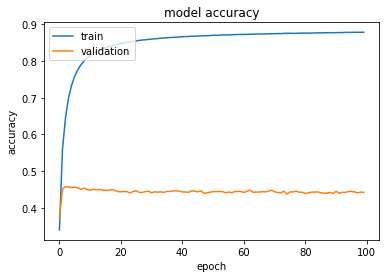

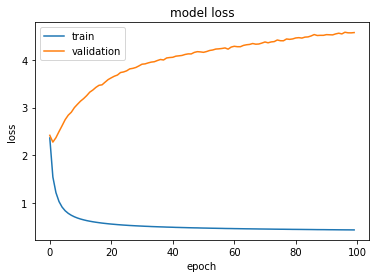

In [28]:
plot_history(history)

### Building model by modifying layers

Lets try a different approach in defining our model by modifying its layers.
In this approach, we will try to build a sequential model with 4 layers. The first layer will be the Embedding layer, the second layer will be a LSTM layer with 128 neurons, the third layer will be a LSTM layer with 64 neurons and the fourth layer will be a Dense layer with the activation function as 'Softmax'. 
The totla number of epochs will be 100.
The loss function and the optimizer will be 'sparse_categorical_crossentropy' and 'nadam' respectively.
Lastly, we will save the model.

In [29]:
if os.path.isfile('model_lstm.h5'):
  model_lstm = tf.keras.models.load_model('model_lstm.h5')
  history_lstm = pd.read_csv('history_lstm.csv')
else:
    model_lstm = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
      tf.keras.layers.LSTM(128, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(n_tokens, activation="softmax")
  ])
    model_lstm.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        "lstm_model", monitor="val_accuracy", save_best_only=True)
    history_lstm = model_lstm.fit(train_set, validation_data=valid_set, epochs=100,
                        callbacks=[model_ckpt])
    history_lstm = pd.DataFrame(history_lstm.history)
    #save model
    model_lstm.save('model_lstm.h5', save_format='h5')
    history_lstm.to_csv('history_lstm.csv',header=True)

Lets see the train and test accuracy for our model where we modified a few layers in comparison to the base model.

In [30]:
present_score('Train', model_lstm, train_set)

937/937 [==============================] - 8s 4ms/step - loss: 0.3818 - accuracy: 0.8873
Train Loss: 0.38176628947257996
Train Accuracy: 0.8873395323753357


In [31]:
present_score('Test', model_lstm, test_set)

107/107 [==============================] - 1s 6ms/step - loss: 4.3659 - accuracy: 0.4434
Test Loss: 4.3658766746521
Test Accuracy: 0.4433617889881134


In [32]:
history_lstm

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.970703,0.183446,2.960014,0.205922
1,1,2.507168,0.289954,2.761482,0.274839
2,2,2.280777,0.344658,2.638269,0.310474
3,3,2.092624,0.394888,2.505472,0.334670
4,4,1.921222,0.446663,2.404005,0.364535
...,...,...,...,...,...
95,95,0.390755,0.885141,4.440964,0.457513
96,96,0.389688,0.885225,4.445163,0.454907
97,97,0.388443,0.885459,4.461504,0.454772
98,98,0.387560,0.885741,4.455616,0.461421


Plot the train accuracy and loss function for the train and test datasets over the epocs.

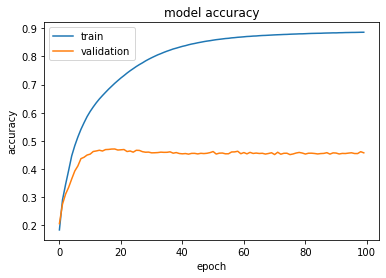

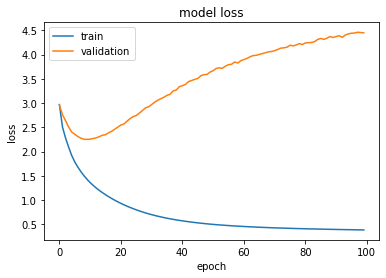

In [33]:
plot_history(history_lstm)

### Building model by modifying optimizer and epochs

In our next approach, we will try to build a sequential model with 3 layers by modifying the optimizer as 'rmsprop' and changing the number of epochs. 
The first layer will be the Embedding layer, the second layer will be a GRU layer with 128 neurons and the third layer will be a Dense layer with the activation function as 'Softmax'.
The loss function and the optimizer will be 'sparse_categorical_crossentropy' and 'rmsprop' respectively.
The number of epochs will be 80.
Lastly, we will save the model.

In [34]:
if os.path.isfile('model_opt.h5'):
  model_opt = tf.keras.models.load_model('model_opt.h5')
  history_opt = pd.read_csv('history_opt.csv')
else:
    model_opt = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
      tf.keras.layers.GRU(128, return_sequences=True),
      tf.keras.layers.Dense(n_tokens, activation="softmax")
  ])
    model_opt.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop",
                  metrics=["accuracy"])
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        "model_opt", monitor="val_accuracy", save_best_only=True)
    history_opt = model_opt.fit(train_set, validation_data=valid_set, epochs=80,
                        callbacks=[model_ckpt])
    history_opt = pd.DataFrame(history_opt.history)
    #save model
    model_opt.save('model_opt.h5', save_format='h5')
    history_opt.to_csv('history_opt.csv',header=True)


The accuracy and loss for our test and train datasets in this approach:

In [35]:
present_score('Train', model_opt, train_set)

937/937 [==============================] - 6s 4ms/step - loss: 0.4457 - accuracy: 0.8739
Train Loss: 0.44574427604675293
Train Accuracy: 0.8739272356033325


In [36]:
present_score('Test', model_opt, test_set)

107/107 [==============================] - 1s 6ms/step - loss: 4.1760 - accuracy: 0.4318
Test Loss: 4.17603063583374
Test Accuracy: 0.4317927658557892


In [37]:
history_opt

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.363608,0.337513,2.517947,0.349052
1,1,1.656674,0.523709,2.346531,0.438816
2,2,1.344564,0.610453,2.370475,0.460305
3,3,1.150804,0.663995,2.445996,0.463113
4,4,1.016159,0.703615,2.566615,0.453046
...,...,...,...,...,...
75,75,0.455517,0.871392,4.384771,0.441810
76,76,0.454780,0.871321,4.399210,0.439645
77,77,0.454253,0.871675,4.412161,0.437259
78,78,0.453097,0.871798,4.449038,0.438714


**Plot the train accuracy and loss function for the train and test datasets over the epocs.**

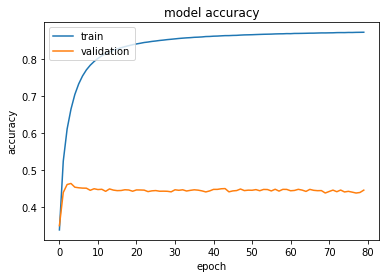

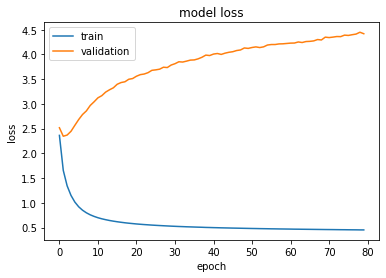

In [38]:
plot_history(history_opt)

### Hyper Tuning with keras tuner

Now, we will try to hypertune our model in order to find the best parameters.
We will define a sequential model that will use paramters between 1-3 GRU layers. The number of neurons can be between 128 to 256 with the step size as 64.

In [39]:
def hypertune_model(hp):
   
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16))
    
    for i in range(1, hp.Int("GRU_num_layers", 1, 4)):
        model.add(
            tf.keras.layers.GRU(hp.Int("GRU_units_" + str(i), min_value=128, max_value=256, step=64), 
                                return_sequences=True)
            )
    
    model.add(tf.keras.layers.Dense(n_tokens, activation="softmax"))
    
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    return model

In [40]:
tuner = keras_tuner.Hyperband(hypertune_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory='hypertuning',
                     seed=12,
                     project_name='hypertuned_model',)

In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
GRU_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
GRU_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
GRU_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
GRU_units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}


We will be building the best model achieved form hypertuning and saving it.

In [42]:
if not os.path.isfile('hypertuned_model.h5'):
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  tuner.search(train_set, epochs=100, validation_data=valid_set, callbacks=[stop_early], verbose=2)
  
  best_hyperparams_all = tuner.get_best_hyperparameters()
  
  # Build model
  hypertuned_best_model = tuner.hypermodel.build(best_hyperparams_all[0])

  # Train the hypertuned model
  hypertuned_history = hypertuned_best_model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[stop_early], verbose=2)
  hypertuned_history = pd.DataFrame(hypertuned_history.history)
else:
  hypertuned_best_model = tf.keras.models.load_model('hypertuned_model.h5')
  hypertuned_history = pd.read_csv('hypertuned_history.csv')

In [43]:
if not os.path.isfile('hypertuned_model.h5'):
  hypertuned_best_model.save('hypertuned_model.h5', save_format='h5')
  hypertuned_history.to_csv('hypertuned_history.csv',header=True)

The accuracy and loss for the train and test dataset for our hypertuned model:

In [44]:
present_score('Train', hypertuned_best_model, train_set)

937/937 [==============================] - 9s 5ms/step - loss: 0.3625 - accuracy: 0.8893
Train Loss: 0.3625178933143616
Train Accuracy: 0.889331579208374


In [45]:
present_score('Test', hypertuned_best_model, test_set)

107/107 [==============================] - 1s 6ms/step - loss: 3.1019 - accuracy: 0.4615
Test Loss: 3.101888418197632
Test Accuracy: 0.461465984582901


In [46]:
hypertuned_history

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,1.884609,0.464649,2.310930,0.460220
1,1,0.826465,0.759879,2.526137,0.477970
2,2,0.528789,0.847253,2.787151,0.477530
3,3,0.436373,0.871917,2.966083,0.465888
4,4,0.399030,0.880304,3.103102,0.474416
5,5,0.378268,0.885278,3.180221,0.460998


Plot the train accuracy and loss function for the train and test datasets over the epocs.

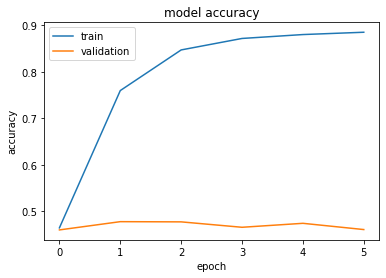

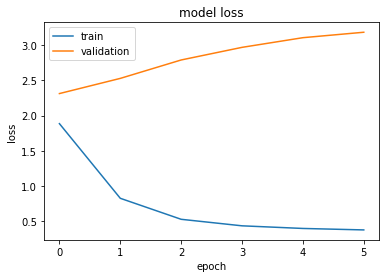

In [47]:
plot_history(hypertuned_history)

In [48]:
predictive_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    hypertuned_best_model
])

Lets define functions to predict the next characters for our story by using the models. 

In [52]:
def next_char(text, temperature=1):
    y_proba = predictive_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [53]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

Now, we will try to predict the text using our "hypertuned_best_model" model and see the results by modifying the temperature. As we increae the temperature, the predicted text makes less sense.

In [54]:
print(extend_text("To be or not to be", temperature=0.001))

To be or not to be was about to mount her horse again, the waiting-w


In [55]:
print(extend_text("beyond that mill you", temperature=0.01))

beyond that mill you!)
por refund set forth
in paragraph 1.e.8.

1.b. 


In [56]:
print(extend_text("To be or not to be", temperature=1))

To be or not to be was jealous off her royal robes to the dwarfs' li


In [57]:
print(extend_text("To be or not to be", temperature=100))

To be or not to be[@hew,s0 pv)s8s'1f_$@. vxzh*951y'#]8)m7'81mr__6yds


**Summary**

In this entire notebook, we tried to do text prediction my modifying layers, optimizers, epochs and even hypertuning with keras tuner. Although we were able to get some results, however, we observed that our dataset was very small and contained only 35,427 characters. Due to this we had the issue of overfitting as we were able to achieve the train accuracy but our test/validation accuracy was pretty bad i.e. approximately 50% and the train accuracy is 89%. 

We can resolve these issues and challenges by getting a bigger dataset and also considering more parameters while hypertuning with keras tuner.